In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from keras.layers import Dense
from keras import Input
#from keras.engine import Model
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers


In [48]:
# from google.colab import drive

# drive.mount('/content/drive')

In [55]:
# data_dir = '/content/drive/MyDrive/Dataset/audiofile_shorted500/'
volume_path = 'C:/Users/GJ/Desktop/연구실/2022SPCUP/WAV_Ordered train set'
# volume_path = 'C:/Users/GJ/Desktop/연구실/2022SPCUP/spcup_2022_training_part1'


FilePathList =[]

for dirName, subdirList, fileList in os.walk(volume_path):
    for filename in fileList:
        if '.csv' not in filename:
            # print(filename)
            FilePathList.append(volume_path+'/'+filename)
        else:
            pd_label = pd.read_csv(volume_path+'/'+filename)

labels = np.array(pd_label['algorithm'])



In [60]:
##파일마다 1초씩 슬라이싱 해서 data augmentation
# X_aug = []

sampling_rate = 16000

y_labels_aug = []
X_spec_aug = []
for i, filepath in enumerate(FilePathList):
    # fig, ax = plt.subplots()
    y, sr = librosa.load(filepath, mono=True, sr = sampling_rate)
    index_f = 0
    for j in range(y.size//sampling_rate):
        X_aug_seg = y[index_f:index_f+sampling_rate]
        
        stft = np.abs(librosa.stft(X_aug_seg, n_fft=512, hop_length=512*3//4))
        spectogram = np.abs(stft)
        X_spec_aug.append(spectogram)
        
        y_labels_aug.append(labels[i])
    
        index_f = index_f+sampling_rate
        #         X_aug_seg = np.expand_dims(X_aug_seg, axis=0)
        #         X_aug.append(X_aug_seg)
# X_aug = np.concatenate(X_aug,axis = 0)
X_spec_aug = np.array(X_spec_aug)
y_labels_aug = np.array(y_labels_aug)
print(X_spec_aug.shape)
print(y_labels_aug.shape)

X = X_spec_aug
Y = y_labels_aug


(32298, 257, 42)
(32298,)


In [72]:
###Train ,Test data split
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# X_train, X_test, y_train, y_test = train_test_split(pad_x_arr, label, test_size=0.2, stratify = label, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify = Y, random_state=42)

print('np.unique(y_train)',np.unique(y_train))

for i in range(5):
    print('전체 데이터 label'+'==',i, '분포 : ', Y.tolist().count(i))
for i in range(5):
    print('train set label'+'==',i, '분포(비율) : ', y_train.tolist().count(i)/Y.tolist().count(i))
for i in range(5):
    print('test set label'+'==',i, '분포 : ', y_test.tolist().count(i))
    
X_train_ = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
print('X_train.shape : ',X_train_.shape)

y_train =to_categorical(y_train) 
y_test = to_categorical(y_test) 
# print(y_test.shape)
print('y_test.shape',y_test.shape)
# print('y : ',y_test[:10])

np.unique(y_train) [0 1 2 3 4]
전체 데이터 label== 0 분포 :  7763
전체 데이터 label== 1 분포 :  5929
전체 데이터 label== 2 분포 :  5853
전체 데이터 label== 3 분포 :  7640
전체 데이터 label== 4 분포 :  5113
train set label== 0 분포 :  0.7999484735282751
train set label== 1 분포 :  0.799966267498735
train set label== 2 분포 :  0.7999316589783018
train set label== 3 분포 :  0.8
train set label== 4 분포 :  0.8001173479366321
test set label== 0 분포 :  1553
test set label== 1 분포 :  1186
test set label== 2 분포 :  1171
test set label== 3 분포 :  1528
test set label== 4 분포 :  1022
X_train.shape :  (25838, 257, 42, 1)
y_test.shape (6460, 5)
y :  [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [85]:
## Train 

from keras.models import Sequential
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(X_train_.shape[1:])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dense(32, activation='relu'))
model.add(Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



early_stopping = EarlyStopping(monitor = 'loss', min_delta = 0, patience = 1, mode = 'auto')

classifier = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=64, callbacks = [early_stopping],
                    validation_split = 0.2)

plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.legend(['val_accuracy', 'accuracy'], loc = 'upper left')
plt.show()

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

Epoch 1/50
 73/323 [=====>........................] - ETA: 50s - loss: 0.8089 - accuracy: 0.6682

KeyboardInterrupt: 

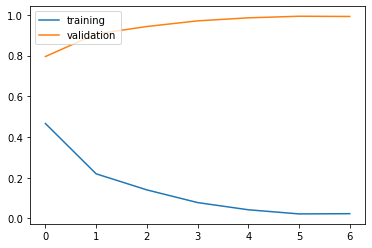

In [82]:
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['accuracy'])
#plt.plot(classifier.history['accuracy'])
plt.legend(['loss', 'accuracy'], loc = 'upper left')
plt.show()

predicted_classes = np.argmax(prediction, axis = 1)

In [ ]:
X = []
Y = []
X_shape_list = []
categories = ["0","1","2","3","4"]
num_classes = len(categories)


for filepath in FilePathList[0:10]:
    y, sr = librosa.load(audioname)  # 모두 1초까지만 자름
    stft = np.abs(librosa.stft(y, n_fft=512, hop_length=128))   # 일반적으로 1/4 가량 겹치게 함
    spectogram = np.abs(stft)
    
#     S = librosa.feature.melspectrogram(y=y, sr=sampling_rate, n_mels=128, fmax=8000)
#     S_dB = librosa.power_to_db(S, ref=np.max)
    #X_shape_second_index = spectogram[1].shape[0]  # 144 같은 shape의 두번째 인자 추출해서 저장
    #X_shape_list.append(X_shape_second_index)
    #X_flatten = np.ravel(spectogram, order='C')  # 1차원으로 flatten 함
    #spectogram = np.pad(X_flatten, (0,(600 - X_shape_second_index)*1025), constant_values=0)  # 가장 큰 두번째 인자의 수가 600 이었으므로 그것의 shape와 같아지도록 제로 패딩해줌
    #spectogram = np.reshape(spectogram,(1025,600))  # reshape
    X.append(spectogram)
    

for idex, category in enumerate(categories):
    label = [0 for i in range(num_classes)]
    label[idex] = 1
    for j in range(100):
        Y.append(label)

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)



(500, 257, 173)
(500, 5)


In [ ]:
#X_shape_list

In [ ]:
# X_list = []
# for i in range(500):
#   X_list.append(X_shape_list[i][0])

# max = np.max(X_list)
# argmax = np.argmax(X_list)

In [ ]:
# max, argmax

(600, 318)

In [ ]:
X[0].shape, X[1].shape, X[318].shape   # 두 번째 인자 : 1025개의 주파수 중 각각의 주파수 당 존재하는 amplitude의 종류 개수? 아닌것 같음...

((257, 173), (257, 173), (257, 173))

In [ ]:
# spectogram[1].shape[0]

144

In [ ]:
# for i in range(100,200,10):
#   plt.figure(figsize=(16,6))
#   plt.subplot(1, 2, 1)   
#   plt.plot(X[i]) 
#   plt.subplot(1, 2, 2)   
#   plt.plot(X[i+100]) 

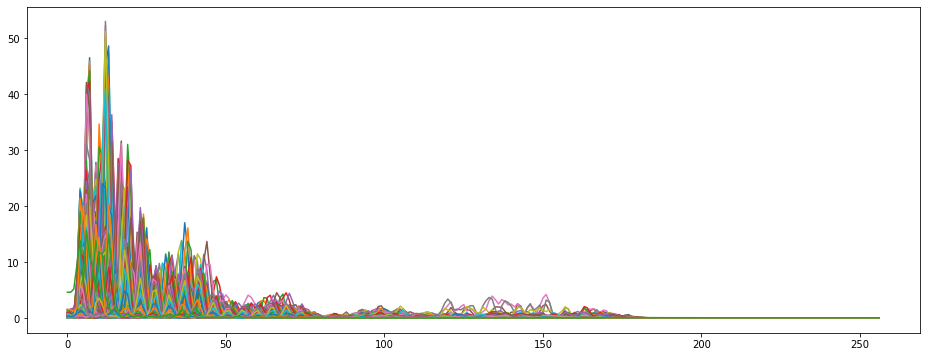

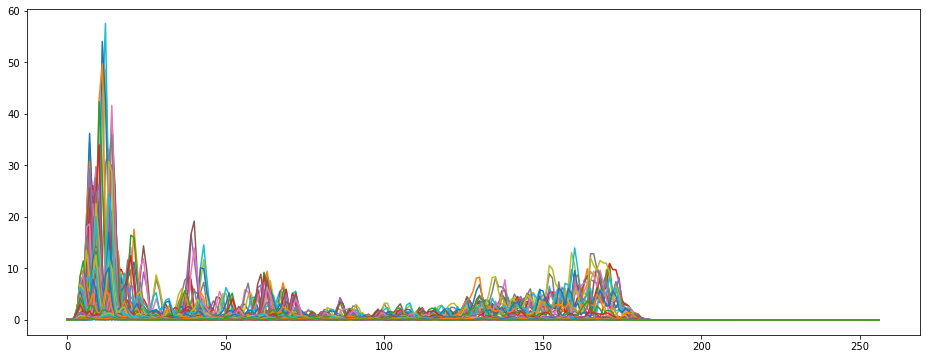

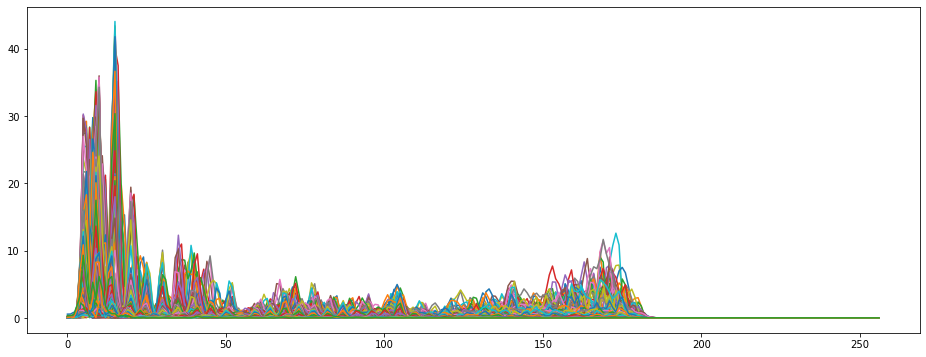

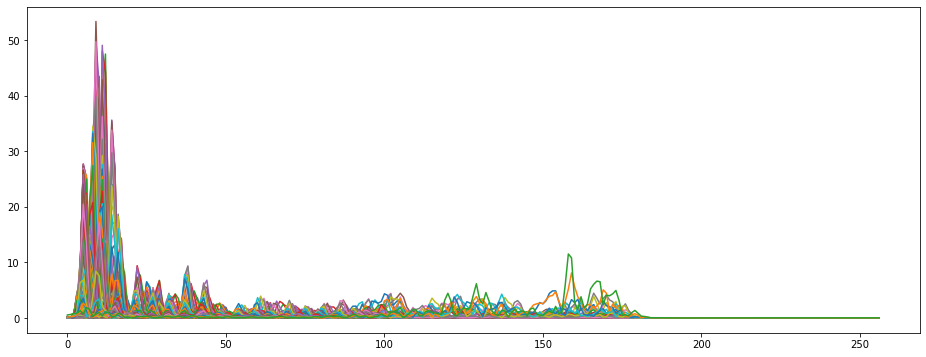

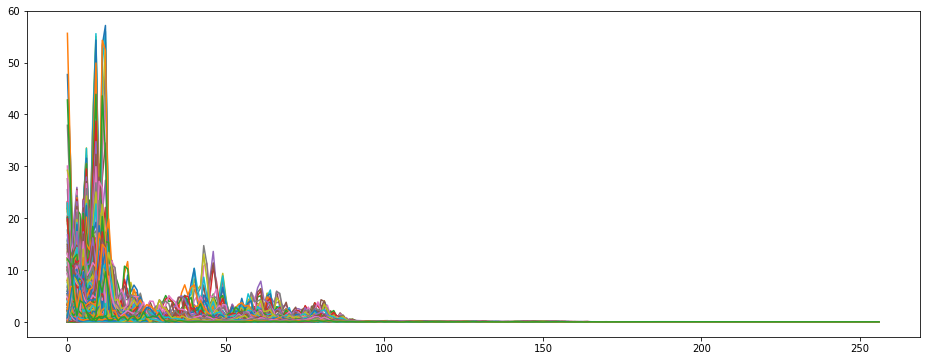

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(X[0])
plt.figure(figsize=(16, 6))
plt.plot(X[100])
plt.figure(figsize=(16, 6))
plt.plot(X[200])
plt.figure(figsize=(16, 6))
plt.plot(X[300])
plt.figure(figsize=(16, 6))
plt.plot(X[400])

In [ ]:
# 알고리즘 1과 알고리즘 2 구분하는 특징 찾아보기
# 1. 평균, 표준편차 정보 확인해보기
A0 = []
A1 = []
A2 = []
A3 = []
A4 = []

for i in range(100):
  A0.append(X[i])
  A1.append(X[i+100])
  A2.append(X[i+200])
  A3.append(X[i+300])
  A4.append(X[i+400])
A0 = np.array(A0)
A1 = np.array(A1)
A2 = np.array(A2)
A3 = np.array(A3)
A4 = np.array(A4)
mean_A0 = np.mean(A0)
mean_A1 = np.mean(A1)
mean_A2 = np.mean(A2)
mean_A3 = np.mean(A3)
mean_A4 = np.mean(A4)
std_A0 = np.std(A0)
std_A1 = np.std(A1)
std_A2 = np.std(A2)
std_A3 = np.std(A3)
std_A4 = np.std(A4)




In [ ]:
mean_A0, mean_A1, mean_A2, mean_A3, mean_A4

(0.5607407, 0.4417758, 0.46932337, 0.43329892, 0.44670874)

In [ ]:
std_A0, std_A1, std_A2, std_A3, std_A4

(2.7375453, 1.8551104, 1.9929006, 1.8474667, 2.2783356)

In [ ]:
# x축이 50, 100, 150 인 곳의 값의 평균
A0_mean50 = []
A1_mean50 = []
A2_mean50 = []
A3_mean50 = []
A4_mean50 = []
for i in range(100):
  A0_mean50.append((X[i][50]+X[i][100]+X[i][150])/3)
  A1_mean50.append((X[i+100][50]+X[i][100]+X[i][150])/3)
  A2_mean50.append((X[i+200][50]+X[i][100]+X[i][150])/3)
  A3_mean50.append((X[i+300][50]+X[i][100]+X[i][150])/3)
  A4_mean50.append((X[i+400][50]+X[i][100]+X[i][150])/3)

A0_mean50 = np.array(A0_mean50)
A1_mean50 = np.array(A1_mean50)
A2_mean50 = np.array(A2_mean50)
A3_mean50 = np.array(A3_mean50)
A4_mean50 = np.array(A4_mean50)

A0_mean50 = np.mean(A0_mean50)
A1_mean50 = np.mean(A1_mean50)
A2_mean50 = np.mean(A2_mean50)
A3_mean50 = np.mean(A3_mean50)
A4_mean50 = np.mean(A4_mean50)



In [ ]:
A0_mean50,A1_mean50,A2_mean50,A3_mean50,A4_mean50

(0.29202756, 0.24290995, 0.25447574, 0.22924966, 0.23906544)

In [ ]:
X_train = np.concatenate((X[0:80],X[100:180],X[200:280],X[300:380],X[400:480]), axis = 0)
X_test = np.concatenate((X[80:100],X[180:200],X[280:300],X[380:400],X[480:500]), axis = 0)
Y_train = np.concatenate((Y[0:80],Y[100:180],Y[200:280],Y[300:380],Y[400:480]), axis = 0)
Y_test = np.concatenate((Y[80:100],Y[180:200],Y[280:300],Y[380:400],Y[480:500]), axis = 0)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(400, 257, 173)
(100, 257, 173)
(400, 5)
(100, 5)


In [ ]:
X_train.shape[1], X_train.shape[2]

(257, 173)

In [ ]:
# CNN 모델에 들어가려면 4차원으로 바꿔줘야함
X_train = X_train.reshape(-1,257,173,1)
X_test = X_test.reshape(-1,257,173,1)

In [ ]:
X_train.shape

(400, 257, 173, 1)

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
# KNN
# nsamples, nx, ny = X_train.shape
# D2_X_train = X_train.reshape((nsamples,nx*ny))
# nsamples, nx, ny = X_test.shape
# D2_X_test = X_test.reshape((nsamples,nx*ny))


# from sklearn.neighbors import KNeighborsClassifier
# clf = KNeighborsClassifier(n_neighbors=3)

# clf.fit(D2_X_train, Y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
# prediction = clf.predict(D2_X_test)

In [ ]:
# predicted_classes = np.argmax(prediction, axis = 1)
# print(predicted_classes)

[0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 1 1 1 3 1 1 3 0 1 3 3 4 3 3 3 2 3
 1 1 1 3 2 2 2 3 2 2 1 4 2 1 0 3 1 3 4 2 1 2 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 3 4 4 4 4 4 4 4 3 0 4 4 4]


In [ ]:
# labels = np.argmax(Y_test, axis=1)
# print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [ ]:
####################################

In [ ]:
1025*70

71750

In [ ]:
144*210

30240

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Conv2D, MaxPooling2D

model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(257, 173, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dense(32, activation='relu'))
model.add(Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

classifier = model.fit(X_train,
                    Y_train,
                    epochs=10,
                    batch_size=64)

plt.plot(classifier.history['loss'])
#plt.plot(classifier.history['accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Conv2D, MaxPooling2D

In [ ]:
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(257, 173, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dense(32, activation='relu'))
model.add(Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
classifier = model.fit(X_train,
                    Y_train,
                    epochs=10,
                    batch_size=64)

Epoch 1/10
7/7 [==============================] - 22s 3s/step - loss: 4.6283 - accuracy: 0.4275
Epoch 2/10
7/7 [==============================] - 15s 2s/step - loss: 1.0168 - accuracy: 0.7425
Epoch 3/10
7/7 [==============================] - 14s 2s/step - loss: 0.4530 - accuracy: 0.8250
Epoch 4/10
7/7 [==============================] - 14s 2s/step - loss: 0.2713 - accuracy: 0.9050
Epoch 5/10
7/7 [==============================] - 14s 2s/step - loss: 0.1392 - accuracy: 0.9600
Epoch 6/10
7/7 [==============================] - 14s 2s/step - loss: 0.0520 - accuracy: 0.9925
Epoch 7/10
7/7 [==============================] - 16s 2s/step - loss: 0.0185 - accuracy: 1.0000
Epoch 8/10
7/7 [==============================] - 18s 2s/step - loss: 0.0094 - accuracy: 1.0000
Epoch 9/10
7/7 [==============================] - 15s 2s/step - loss: 0.0020 - accuracy: 1.0000
Epoch 10/10
7/7 [==============================] - 15s 2s/step - loss: 0.0010 - accuracy: 1.0000


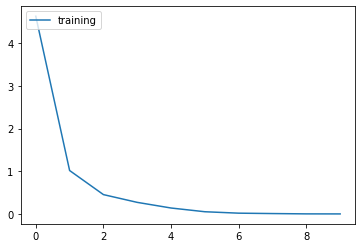

In [ ]:
plt.plot(classifier.history['loss'])
#plt.plot(classifier.history['accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('테스트 정확도:', test_acc)

4/4 - 1s - loss: 0.9824 - accuracy: 0.8000 - 1s/epoch - 279ms/step
테스트 정확도: 0.800000011920929


In [ ]:
prediction = model.predict(X_test)

In [ ]:
predicted_classes = np.argmax(prediction, axis = 1)
print(predicted_classes)

[0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 3 1 1 1 2 1 0 1 2 0 3 1 2 1
 1 1 1 2 2 2 1 2 2 2 2 1 2 2 2 3 1 1 4 2 1 2 3 3 3 1 3 3 3 3 3 3 2 3 3 3 3
 3 3 1 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4]


In [ ]:
labels = np.argmax(Y_test, axis=1)
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [ ]:
## 특징 추가한 경우

In [ ]:
257*173 + 3

44464

In [ ]:
112*397

44464

In [ ]:
F0 = np.array([mean_A0,std_A0,A0_mean50])
F1 = np.array([mean_A1,std_A1,A1_mean50])
F2 = np.array([mean_A2,std_A2,A2_mean50])
F3 = np.array([mean_A3,std_A3,A3_mean50])
F4 = np.array([mean_A4,std_A4,A4_mean50])

In [ ]:
F0, F1, F2, F3, F4

(array([0.5607407 , 2.7375453 , 0.29202756], dtype=float32),
 array([0.4417758 , 1.8551104 , 0.24290995], dtype=float32),
 array([0.46932337, 1.9929006 , 0.25447574], dtype=float32),
 array([0.43329892, 1.8474667 , 0.22924966], dtype=float32),
 array([0.44670874, 2.2783356 , 0.23906544], dtype=float32))

In [ ]:
X[0]

array([[1.08268420e-11, 2.34355874e-04, 2.47036153e-03, ...,
        3.05374175e-01, 1.54900944e+00, 4.60749102e+00],
       [1.09116665e-11, 2.23718656e-04, 2.09270418e-03, ...,
        2.39557505e-01, 1.47156334e+00, 4.58690119e+00],
       [1.11340590e-11, 1.94184366e-04, 1.23246899e-03, ...,
        3.14135909e-01, 1.29398024e+00, 5.15199661e+00],
       ...,
       [1.28262290e-10, 3.88163598e-11, 3.09258119e-10, ...,
        3.55681863e-07, 1.01084802e-02, 3.20145488e-02],
       [1.27959407e-10, 2.87035326e-11, 3.14169246e-10, ...,
        1.97740917e-07, 1.01065878e-02, 3.20078507e-02],
       [1.27858737e-10, 2.52588384e-11, 2.45360648e-10, ...,
        2.65432988e-07, 1.01055764e-02, 3.20056379e-02]], dtype=float32)

In [ ]:
X2 = []
for i in range(100):
  X_flatten0 = np.ravel(X[i], order='C')
  X_flatten0 = np.append(X_flatten0, F0)
  custom_spectogram0 = np.reshape(X_flatten0,(112,397))  # reshape
  X2.append(custom_spectogram0)

  X_flatten1 = np.ravel(X[i+100], order='C')
  X_flatten1 = np.append(X_flatten1,F1)
  custom_spectogram1 = np.reshape(X_flatten1,(112,397))  # reshape
  X2.append(custom_spectogram1)
  
  X_flatten2 = np.ravel(X[i+200], order='C')
  X_flatten2 = np.append(X_flatten2,F2)
  custom_spectogram2 = np.reshape(X_flatten2,(112,397))  # reshape
  X2.append(custom_spectogram2)

  X_flatten3 = np.ravel(X[i+300], order='C')
  X_flatten3 = np.append(X_flatten3,F3)
  custom_spectogram3 = np.reshape(X_flatten3,(112,397))  # reshape
  X2.append(custom_spectogram3)

  X_flatten4 = np.ravel(X[i+400], order='C')
  X_flatten4 = np.append(X_flatten4,F4)
  custom_spectogram4 = np.reshape(X_flatten4,(112,397))  # reshape
  X2.append(custom_spectogram4)

X2 = np.array(X2)
print(X2.shape)
print(Y.shape)

(500, 112, 397)
(500, 5)


In [ ]:
X2_train = np.concatenate((X2[0:80],X2[100:180],X2[200:280],X2[300:380],X2[400:480]), axis = 0)
X2_test = np.concatenate((X2[80:100],X2[180:200],X2[280:300],X2[380:400],X2[480:500]), axis = 0)
Y_train = np.concatenate((Y[0:80],Y[100:180],Y[200:280],Y[300:380],Y[400:480]), axis = 0)
Y_test = np.concatenate((Y[80:100],Y[180:200],Y[280:300],Y[380:400],Y[480:500]), axis = 0)

print(X2_train.shape)
print(X2_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(400, 112, 397)
(100, 112, 397)
(400, 5)
(100, 5)


In [ ]:
X2_train = X2_train.reshape(-1,112,397,1)
X2_test = X2_test.reshape(-1,112,397,1)

In [ ]:
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(112, 397, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dense(32, activation='relu'))
model.add(Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
import tensorflow as tf

tf.config.run_functions_eagerly(True)
classifier = model.fit(X2_train,
                    Y_train,
                    epochs=20,
                    batch_size=64)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


7/7 [==============================] - 21s 3s/step - loss: 6.6320 - accuracy: 0.2075
Epoch 2/20
7/7 [==============================] - 20s 3s/step - loss: 1.5890 - accuracy: 0.2625
Epoch 3/20
7/7 [==============================] - 20s 3s/step - loss: 1.5569 - accuracy: 0.2550
Epoch 4/20
7/7 [==============================] - 20s 3s/step - loss: 1.5158 - accuracy: 0.2850
Epoch 5/20
7/7 [==============================] - 20s 3s/step - loss: 1.4143 - accuracy: 0.3475
Epoch 6/20
7/7 [==============================] - 20s 3s/step - loss: 1.3179 - accuracy: 0.3950
Epoch 7/20
7/7 [==============================] - 20s 3s/step - loss: 1.2137 - accuracy: 0.4500
Epoch 8/20
7/7 [==============================] - 20s 3s/step - loss: 1.0770 - accuracy: 0.5050
Epoch 9/20
7/7 [==============================] - 20s 3s/step - loss: 0.9428 - accuracy: 0.5775
Epoch 10/20
7/7 [==============================] - 20s 3s/step - loss: 0.8300 - accuracy: 0.6325
Epoch 11/20
7/7 [==============================] -

In [ ]:
test_loss, test_acc = model.evaluate(X2_test,  Y_test, verbose=2)
print('테스트 정확도:', test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


4/4 - 2s - loss: 4.5416 - accuracy: 0.2100 - 2s/epoch - 402ms/step
테스트 정확도: 0.20999999344348907


In [ ]:
prediction = model.predict(X2_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
predicted_classes = np.argmax(prediction, axis = 1)
print(predicted_classes)

[2 2 2 2 3 3 0 4 2 3 4 3 2 0 2 1 2 1 2 1 3 2 2 4 3 4 3 2 2 2 2 0 0 4 2 1 1
 2 2 3 0 2 3 2 2 4 1 2 2 3 4 4 2 3 2 2 2 3 2 3 4 3 3 2 3 2 0 0 3 0 2 0 0 0
 2 2 3 0 2 0 4 2 2 0 2 1 2 2 3 2 1 0 3 3 0 0 0 0 2 4]


In [ ]:
labels = np.argmax(Y_test, axis=1)
print(labels)